### Patient Reviews

In [ ]:
%pip install pandas matplotlib pm4py

In [1]:
# Importing all necessary libraries/environments here
import pandas as pd

##### Basic Data Exploration

In [2]:
file_path = r"D:\Data Mining\Data Mining Exam\Part B\PatientReviews.csv"
df = pd.read_csv(file_path)

# Data Exploration
df.info()
print(df.columns)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   patient        690 non-null    object
 1    action        690 non-null    object
 2    org:resource  690 non-null    object
 3    DateTime      690 non-null    object
dtypes: object(4)
memory usage: 21.7+ KB
Index(['patient', ' action', ' org:resource', ' DateTime'], dtype='object')


,patient,action,org:resource,DateTime
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11
1,patient 0,Blood test,Lab,2017-01-02 12:47:33
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09


#### Data Preprocessing

In [3]:
# Check for missing values
missing_count = df.isnull().sum() # Count total missing values
rows_with_missing = df.isnull().any(axis=1).sum()  # Count rows with missing values

if rows_with_missing > 0:
    df = df.dropna()
    print(f"Dropped {rows_with_missing} rows containing missing values.")
else:
    print("No missing values found. No rows were dropped.")

No missing values found. No rows were dropped.


In [4]:
# stripping spaces in column names
df.columns = df.columns.str.strip()

In [5]:
# Check & removal of duplicates (Same patient, action, org:resource & DateTime)
duplicates = df[df.duplicated(subset=['patient', 'action', 'org:resource', 'DateTime'], keep=False)]

# Number and all duplicated rows
print(f"Total duplicated rows: {duplicates.shape[0]}")

# Removing duplicates while keeping the first occurrence
df = df.drop_duplicates(subset=['patient', 'action', 'org:resource', 'DateTime'], keep="first")

df.info()

Total duplicated rows: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   patient       690 non-null    object
 1   action        690 non-null    object
 2   org:resource  690 non-null    object
 3   DateTime      690 non-null    object
dtypes: object(4)
memory usage: 21.7+ KB


#### Generating Event Logs

In [12]:
import pm4py

# Renaming the columns to match the process mining format
df = df.rename(columns={
    'patient': 'case:concept:name',  # Case ID
    'action': 'concept:name',        # Activity name
    'org:resource': 'org:resource',  # Resource performing the action
    'DateTime': 'time:timestamp'     # Timestamp column
}, errors="ignore")

# Ensure 'time:timestamp' is in datetime format
df['time:timestamp'] = pd.to_datetime(df['time:timestamp'], errors='coerce')

# Drop rows with missing or invalid timestamps
df = df.dropna(subset=['time:timestamp'])

# Converting the dataframe into an Event Log format using PM4Py
event_log = pm4py.convert_to_event_log(df)

# Saving the event log as a .xes file
save_path = r"D:\Data Mining\Data Mining Exam\Part B\Question_2.xes"
pm4py.write_xes(event_log, save_path)

print(f"\nEvent log saved successfully as Question_2.xes")


exporting log, completed traces ::   0%|          | 0/100 [00:00<?, ?it/s]

exporting log, completed traces :: 100%|██████████| 100/100 [00:00<00:00, 7291.40it/s]


Event log saved successfully as Question_2.xes


#### Bar Graph showing “actions” undertaken at the hospital between January 2017 and June 2017

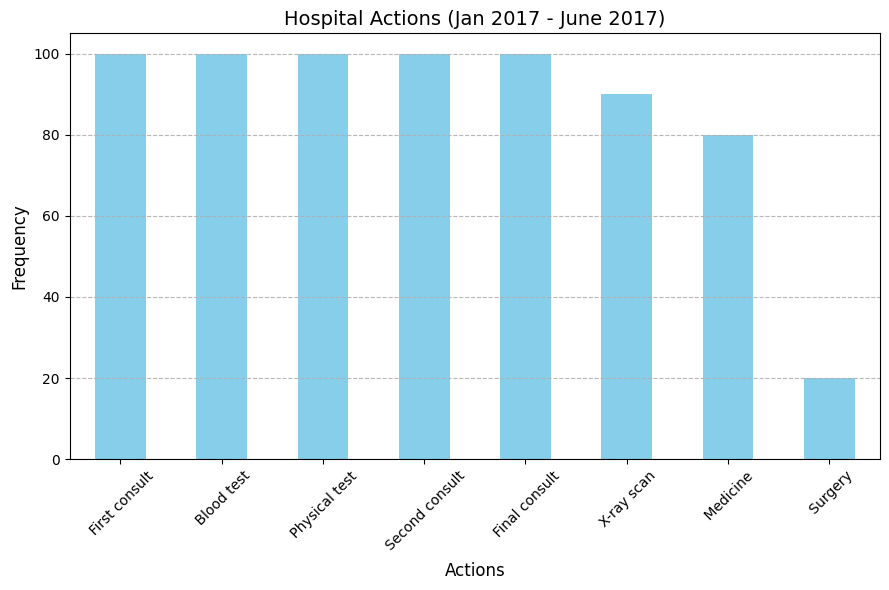

In [9]:
import matplotlib.pyplot as plt

# Filter data between January 2017 and June 2017
start_date = '2017-01-01'
end_date = '2017-06-30'
df_filtered = df[(df['time:timestamp'] >= start_date) & (df['time:timestamp'] <= end_date)]

# Count per action
action_counts = df_filtered['concept:name'].value_counts()

# Bar chart plot
plt.figure(figsize=(9, 6))
action_counts.plot(kind='bar', color='skyblue')

# Labels and title
plt.xlabel('Actions', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Hospital Actions (Jan 2017 - June 2017)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.9)

# plot
plt.tight_layout()
plt.show()


#### Process Mining to generate flow of "actions" undertaken at the Hospital

In [10]:
# loading saved event logs
logs = pm4py.read_xes(r'D:\Data Mining\Data Mining Exam\Part B\Question_2.xes')
logs

parsing log, completed traces :: 100%|██████████| 100/100 [00:00<00:00, 6820.34it/s]


,concept:name,org:resource,time:timestamp,case:concept:name
0,First consult,Dr. Anna,2017-01-02 11:40:11+00:00,patient 0
1,Blood test,Lab,2017-01-02 12:47:33+00:00,patient 0
2,Physical test,Nurse Jesse,2017-01-02 12:53:50+00:00,patient 0
3,Second consult,Dr. Anna,2017-01-02 16:21:06+00:00,patient 0
4,Surgery,Dr. Charlie,2017-01-05 13:23:09+00:00,patient 0
...,...,...,...,...
685,X-ray scan,Team 2,2017-05-25 11:03:27+00:00,patient 99
686,Physical test,Nurse Corey,2017-05-25 11:55:24+00:00,patient 99
687,Second consult,Dr. Anna,2017-05-29 15:12:39+00:00,patient 99
688,Medicine,Pharmacy,2017-05-29 16:17:13+00:00,patient 99


In [11]:
from pm4py.visualization.petri_net import visualizer as pn_visualizer

# Discovering the process model using Heuristic Miner
heu_net, initial_marking, final_marking = pm4py.algo.discovery.heuristics.algorithm.apply(logs)

# Visualizing the discovered process model using the Petri net visualizer
gviz = pn_visualizer.apply(heu_net, initial_marking, final_marking)

# Save and view the visualization
print("\n The flow of “actions” undertaken at the hospital is saved as: Flow_of_Actions.png")
gviz.render('Flow_of_Actions', format='png', view=True) # This step requires Graphviz to be installed and added to system PATH


 The flow of “actions” undertaken at the hospital is saved as: Flow_of_Actions.png


'Flow_of_Actions.png'